## 내 제출과제에 대한 피드백

* Train, Validation, Test 데이터의 비율은 8:1:1 정도가 보통
<br><br>
* Flatten은 사진 등 이미지에 많이 사용, 필요 없을 수 있다
* model.compile의 metric
  * f1-score는 여러 종류가 있음
    * imbalance한 상황에서 이상거래 등에 가중치를 주는 weighted f1-score
    * class별로 하는 macro f1-score
    * micro f1-score
  * 이런 상황에서 지원되는 metric이 vanila f1-score라면 점수가 안좋게 나온 것일수도 있다
    * **weighted f1-score와 같은 것을 사용하는 편이 적절히 평가될 수 있음**
    * **recall, precision을 모두 넣고 볼 수도 있음**
    * model build 대비 점수가 낮게 나와서, metric 문제일 가능성이 높아보임
<br><br>
* Hyper parameter Optimizer (발표과제에서는 Keras Tuner 사용)
  * 개념
    * 예를 들어 10개 파라미터에 100개 선택지가 있다면 $100^{10}$과 같이 계산량이 많음
      * (Brute force방식) 모든 조합을 계산하여 최적조합을 찾는 방식은 계산량 문제로 어려움
    * 전체 계산 중 일부만 계산하는 방식으로, 전문가만큼의 성능은 안나오지만 초보의 수준에서는 좋음
  * Random search, Grid search
    * Grid search : 나머지 파라미터를 고정시킨 채 최적 파라미터를 도출하는 것을 반복하여, 최적 파라미터만 조합
      * 최적이 아닌 파라미터들의 조합으로 최적 성능이 나올 수 있다는 단점
    * Random Search : 파라미터들의 '조합'이라는 부분을 Grid search보다 좀 더 보기위한 방법
  * 추가용도
    * 모델을 확정한 후, 모델의 성능을 좀 더 높이기 위해서도 사용 가능
      * 예를 들면 모델을 분석하고 보고서를 쓰는 코딩테스트도 있는데, 이럴 때 조금이라도 성능을 올리기 위해 사용가능
  * Hyper parameter관련 보고서를 쓴다면, 어떤 기법을 추가하여 유용하고 좋았는지 비교하는 것이 좋음
<br><br>
* Early stopping 설정
  * epoch수 대비 3%정도로 설정하기도 함
  * 실질적으로는 전체 epoch을 돌리고, 가장 성능이 좋았던 포인트를 사용하는 방법을 사용(모든 포인트의 고려)
<br><br>
* 참고
  * 이후 새로운 거래가 생겨 모델로 판별하려면, 학습데이터와 같이 PCA처리 후 input 해야함
  * 매번 현재의 과제처럼 튜닝을 새로하기보다는, 전 모델의 튜닝을 지속하는 것이 효율적임
    * Layer수, Activation function 등은 변경 불가한 요소
    * Learning rate scheduler, early stopping 등의 변경 가능

## 과제 보완 계획

### Data set 분석
* t-sne를 통해 데이터의 분포 등을 시각화하여 파악해봄
* 내가 어느정도의 분류는 가능하겠다는 정도를 파악할 수 있음

### Data set 구성
* Train/Validation/Test를 8:1:1로 구성
* train_test_split(stratify=실제Label)을 통한 Label 비중 맞추기 검토
* Validation set은 StratifiedKFold 적용 검토
* 컬럼별 이상치 처리 : Box plot의 Upperbound나 Underbound값으로 대체 고려(제거X)
  * Robust scaler 고려

### Parameter 등 모델구성
* optuna적용고려, Randomsearch, GridSearch 확인 후 선택
* metric을 weighted f1-score나 recall&precision 등을 고려
  * 예시 : metrics = [f1_score, Precision(), Recall()]
  ```python
    import tensorflow_addons as tfa
    f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    model.compile(loss=SigmoidFocalCorssEntropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[f1_score, Pricision(), Recall()])
  ```
* Early stopping은 코드구현은 하되 실질적으로는 무효가되는 patience인 경우도 추가로 설정
  * 전체 epoch을 돌려 가장 성능이 좋은 포인트도 확인한 후 대조
* Learning rate scheduling은 기존의 별도 함수를 만드는 방식 외, ReduceLROnPlateau 함수 이용도 고려
```python
  from tf.keras.callbacks import ReduceLROnPlateau
  reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                factor=0.2, # lr감소치. 현재 lr이 0.01이라면 0.01*0.2를 적용
                patience=10, # 개선에 대한 허용치. 10 epoch까지 개선이 없다면 적용
                mode='min', # auto, max, min 옵션 있음
                min_lr=0.001)
  model.fit(x_train, y_train, callbacks=[reduce_lr])
```
* Batch size는 가능한 선에서는 늘려서 빠른 학습을 도모

* 평가시 ROC Curve나 PR Curve 시각화도 고려
* Cross validation 활용시, 여러번의 모델Score가 나오므로 Box plot을 통해 안정적인 모델인지 시각화

### 기타
* 시각화를 통해 데이터 설명 보강
  * ROC Curve나 PR Curve 등의 사용

### 추가진행
* 머신러닝 기법 활용
  * 모델 : XGB, Random forest 고려
  * 데이터셋 : 샘플링(오버 또는 언더) 적용 검토
    * 오버샘플링 한다면 SMOTE대신 ADASYN적용검토
    * 샘플링 적용/미적용 성능 비교
      * 위의 모델 또는 Logistic regression으로 비교
  * 모델학습 : Cross validation을 통한 과적합 방지
  * Threshold adjustment 고려

## 7주차 발표과제들 보완에 필요한 추가지식

* 불균형한 데이터를 맞춰주는 샘플링 기법 : 오버샘플링, 언더샘플링
  * 주의점 : 두 기법 모두 Test data를 먼저 분리해둔 후 나머지에 대해 적용. Test data는 건드리지 않는다
  * 언더샘플링과 오버샘플링은 둘 중 하나만 사용하는게 나음(함께 사용시 둘의 단점을 모두 가질수도 있다)
  * 참고사항
    * 가급적이면 언더샘플링보다는 오버샘플링을 많이 씀 (데이터는 자산이라는 관점에서, 손실 방지)
    * 추세는 발전된 알고리즘의 모델에 맡기고, 샘플링을 적용하지 않는 방향
      * 다만 상황에 따라서는 오버샘플링이 훨씬 좋을 때가 있음
        * 로지스틱회귀는 최신의 복잡한 알고리즘이 아닌 단순한 모델로, 편중된 데이터에 취약한데 여기에는 궁합이 좋음
        * XGBoost나 Neural Network같은 복잡한 모델에는 오히려 안좋을 수 있음
  * 오버샘플링 & 언더샘플링
    * 오버샘플링 : 부족한 데이터를 늘림
      * 장점 : 데이터의 손실이 없음
      * 단점 : 데이터를 늘리기 위해 같은 데이터를 반복하면서 노이즈 발생
             : Precision이 낮아진다(Recall은 높아진다)
        * SMOTE가 이를 보완하기 위한 오버샘플링 기법이지만 근본적으로는 데이터가 반복되는 것은 같음
        * (별도확인) ADASYN으로 SMOTE의 단점을 보완가능(SMOTE와 달리 다른 클래스의 데이터 수도 고려하여 증강)
        ```python
        from imblearn.over_sampling import SMOTE, ADASYN
        ```
    * 언더샘플링 : 많은 쪽의 데이터를 부족한 데이터만큼 남기고 버림
      * 단점 : 데이터를 버린다는 손실
      * function이 아니라 직접 구현한다면, 순서대로 가져오지 않고 Random하게 가져오도록 구현
    * 샘플링을 통해, 이상거래에 더 잘 반응할 수 있는 모델로 만들어 줄 수 있음
      * 다만 고객 입장에서는 정상거래인데 이상거래로 판단되게 되는 불편함이 생길 수 있음

* `StratifiedKFold` : 특정 Label이 많거나 적어서 `분포가 Imbalance한 경우 활용`
  * Validation set을 나누는 기법이므로, Test set 분리 후 적용
  * `fold `: 같은 Data set에서, 각 부분을 모두 Validation으로 활용할 수 있도록 반복
    * `데이터가 적을 때, 있는 데이터를 최대한 활용`해, Validation set을 다양하게 만들 수 있다
    * 예를 들어 100개 데이터에 5 fold를 적용한다면, 아래와 같이 구성됨(굵은 부분이 validation set)
      * **1~20**, 21~100 / 1~20, **21~40**, 41~100 / 1~40, **41~60**, 61~100 / 1~60, **61~80**, 81~100 / 1~80, **81~100**
  * 참고 코드
  ```python
    skfold = StratifiedKFold(n_split=5, random_state=None, Shuffle=False)
    for train_index, test_index in skfold.split(X,Y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
  ```

* 이상치 데이터에 대한 처리 : 제거 vs 대체
  * 제거는 데이터의 손실이므로 대체가 더 좋을 때도 있음
    * Box plot 기준으로 Upper bound이상의 값들은 Upper bound값으로 치환하는 것도 방법

* `차원축소(t-sne, PCA , SVD등)`
  * 차원축소 : Feature들을 `상관관계가 없는 Feature로 바꾸는 것`을, 수학적인 방법으로 적용 
    * 예를 들어 100개의 feature 중 연봉과 월급은 중복(상관관계있음)이므로 차원축소 적용 후 10개의 feature로 mapping
  * 대표적으로 PCA가 있음, 현재의 데이터는 이미 PCA가 적용되어 있음
  * 종류
    * `PCA` : 상관관계를 없애며 전처리 가능
    * `SVD`(간단하게 PCA를 확장한 것으로 볼 수 있음. 전처리 가능)
    * `t-sne` : 저차원으로 mapping 하여 시각화 용이 (전처리는 불가)
  * 유의사항 : `PCA나 SVD는 선형적인 관계가 있을때만 적용`한다(`비선형적인 정보는 손실`되므로 `모델성능하락`이 있을 수 있다)

* Plot을 그렸을 때 fold의 수만큼 점으로 나오게 됨(5fold면 5개) <br>
  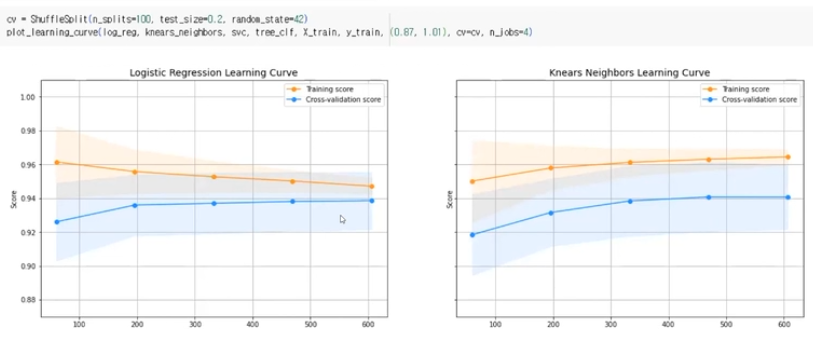<br>

* Recall, Precision은 Trade-off, 2개 모두 준수한 Sweet spot을 찾기 위해 함께 볼 수 있는 방법
  * f1-score : 조화평균을 활용한 하나의 숫자로 판단 가능
  * ROC Curve : TP와 FP를 x, y축으로 두고 면적으로 판단 가능(넓을수록 좋음, 0~1값 가짐)
  * PR(Precision-Recall) Curve : Precision과 Recall을 x, y축으로 두고 면적으로 판단 (넓을수록 좋음)

* Binary 문제의 경우, Simoid 대신 2개 뉴런의 Softmax도 가능함
* Batch size는 관례(2의 배수)를 맞추는 것이 좋음 (보고서 확인의 관점에서는 안좋은 시선으로 보게될 수 있다)

* 이상치 Robustscaler

* train_test_split(stratify=실제Label)옵션으로 Label의 비율을 비슷하게 샘플링 가능
* 오버샘플링의 단점 : precision이 낮아진다
  * precision은 판정한 건 중 실제의 비율이고, 오버샘플링으로 정상거래를 이상거래로 판정하는건이 많아짐
  * recall의 측면에서는 오버샘플링을 통해 판정을 늘리는게 나을 수 있음(암환자 사례)

* 데이터 불균형에서의 가중치 설정 : Class(label)분포 기반 가중치 설정
  * 더 중요하게 보는 것에 패널티를 더 크게 줌
  * 정상거래(0) 284315건, 이상거래(1) 492건인 경우의 예시
    ```python
      total_samples = 284315 + 492
      weight_for_0 = total_samples / ( 2 * 284315)
      weight_for_1 = total_samples / (2 * 492)
      class_weights = {0:weight_for_0, 1:weight_for_1}

      model.fit(x_train, y_train, class_weight=class_weights)
    ```
  * Neural network에서 해결할 수 있는 부분이어서 오히려 혼동을 줄 수도 있다
    * **모델 알고리즘이 복잡한 경우**는, Weight에서 패널티를 다르게 주는 focal loss나 오버샘플링을 잘 쓰지 않음
      * Neural network에 Sigmoid focal CrossEntrophy를 통해 패널티를 높게 주어 긍정적 효과를 기대했지만, 오히려 성능하락될 수 있음
    * **모델 알고리즘이 단순한 Logistic regression 등은**, 이러한 Weighted loss가 효과가 좋을 수 있음

* Learning rate scheduler 함수로 구현 예시
```python
  from tf.keras.callbacks import ReduceLROnPlateau
  reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                factor=0.2, # lr감소치. 현재 lr이 0.01이라면 0.01*0.2를 적용
                patience=10, # 개선에 대한 허용치. 10 epoch까지 개선이 없다면 적용
                mode='min', # auto, max, min 옵션 있음
                min_lr=0.001)
  model.fit(x_train, y_train, callbacks=[reduce_lr])
```

* Dropout은 간단한 모델이라면 높게 설정할지 않아도 괜찮음

* Batch size는 데이터가 적거나 장비(메모리) 상황이 좋다면 늘려서 빠르게 학습

* 과적합(Overfitting)의 원인
  * 모델 자체의 문제, 앞단계인 데이터 전처리나 샘플링, Data split 등의 문제일 수 있음
  * 단순히 성능이 안나왔다해서 과적합으로 판단은 금물

* LDA (Linear discriminant Anaylsis) : 분류문제에서는 Logistic Regression 좋은 성능
* KNN (K-Nearest Neighbor) : 근접(이웃)한 데이터들을 분류
* Cart : 의사결정나무(Decision Tree)의 기본 모델
* Random forest : 여러개의 트리 모델을 만들고, 다수결로 정함. **앙상블 모델**
* Boosting 계열 모델 : 학습 후, 틀린 부분에 가중치를 두면서 학습 반복
  * 처음에는 이상거래에 대해 많이 틀리다가, 점점 잘 잡아내도록 학습됨.
  * XGB를 많이 사용 
* 이외에 Catboost 등도 있음

* 현재와 같은 20만건 정도의 데이터는, 최신계열의 복잡한 머신러닝에서 더 성능이 좋을 수 있음
* Cross validation 활용시, 여러번의 모델Score가 나오므로 Box plot을 통해 안정적인 모델인지 확인 가능

* 모델의 선택 (SOTA가 기준이 되어야 하는지에 대한 질문)
  * 문제 정의(상황이 어떤 문제인지 정의할 능력 필요)
  * 어떤 계열의 모델이 적합한지 선택 (전반적인 머신러닝 등 모델 지식 필요)
  * SOTA(State of the art)는 이후의 문제

* 논문 등을 볼 때는 문제 Setup까지 본 후, 바로 풀이보지말고 먼저 고민 후 보기

* Random forest모델 사용시 두가지 고려사항
  * Cross validation을 통한 과적합 방지
    * 앙상블모델은 복잡한 머신러닝 기법에 속하고, XGB나 Random forest는 과적합 일어날 수 있음
  * Hyper parameter tuning을 통한 개선

* Thresholding(임계값 조정)
  * Precision과 recall은 trade-off. 원하는 것은 둘 다 높은 Spot
    * 이러한 Sweet spot을 시각적으로는 ROC/PR Curve로 확인, 코드로는 Threshold adjustment 조절
    * Threshold 예시 일부
    ```python
      y_scores = model.predict_proba(X_test)[:, 1]
      precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

      f1_score = 2 * precision * recall / (precision + recall)
      optimal_idx = np.argmax(f1_scores)
      optimal_threshold = thresholds[optimal_idx]
    ```